# 4. Modélisation — baselines (Dummy → LogReg → RandomForest)

Objectifs :
1. construire un pipeline scikit-learn robuste (préprocessing + modèle)
2. comparer 3 modèles (étalon, linéaire, non-linéaire)
3. évaluer avec des métriques adaptées au déséquilibre de classes (PR-AUC, precision/recall)
4. préparer la sélection d’un seuil métier via la courbe précision-rappel

Important : à ce stade, l’objectif n’est PAS de “maximiser le score”, mais de sécuriser une base fiable et interprétable.


## Données utilisées

On utilise le dataset enrichi `employees_features.parquet` produit à l’étape précédente.

La cible `a_quitte_l_entreprise` est binaire et potentiellement déséquilibrée :  
→ on évite de se fier à l’accuracy seule.


In [6]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("technova_attrition_baselines")
mlflow.sklearn.autolog()

g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/17 12:32:16 INFO mlflow.tracking.fluent: Experiment with name 'technova_attrition_baselines' does not exist. Creating a new experiment.


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

from technova_attrition.config import PATHS, SETTINGS
from technova_attrition.evaluation import (
    evaluate_classifier,
    find_threshold_for_recall,
    plot_precision_recall,
)
from technova_attrition.modeling import make_dummy, make_logreg, make_random_forest
from technova_attrition.preprocessing import FeatureGroups

df = pd.read_parquet(PATHS.data_processed / "employees_features.parquet")

TARGET = "a_quitte_l_entreprise"
assert TARGET in df.columns

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SETTINGS.random_state,
    stratify=y,
)
y.value_counts(normalize=True).round(3)

a_quitte_l_entreprise
0    0.839
1    0.161
Name: proportion, dtype: float64

In [8]:
# === Numériques ===
num_cont = [
    "age",
    "augmentation_salaire_precedente",
    "distance_domicile_travail",
    "proba_chgt_experience_par_an",
    "proba_chgt_experience_par_an_adulte",
    "ratio_experience_vie_adulte",
]

num_log = [
    "revenu_mensuel",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "annees_depuis_la_derniere_promotion",
]

num_disc = [
    "nombre_participation_pee",
    "nb_formations_suivies",
    "nombre_employee_sous_responsabilite",
    "nombre_experiences_precedentes",
    "nombre_experiences_precedents",
]

# === Binaires ===
bin_cols = ["genre", "heure_supplementaires", "changement_poste"]

# === Nominales ===
cat_nom = ["statut_marital", "departement", "poste", "domaine_etude"]

# === Ordinales ===
cat_ord = [
    "satisfaction_employee_environnement",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_precedente",
    "note_evaluation_actuelle",
    "niveau_hierarchique_poste",
    "niveau_education",
    "frequence_deplacement",
    "evolution_note",
]


# Nettoyage automatique : on ne garde que les colonnes présentes
def keep_existing(cols):
    return [c for c in cols if c in X.columns]


num_cont = keep_existing(num_cont)
num_log = keep_existing(num_log)
num_disc = keep_existing(num_disc)
bin_cols = keep_existing(bin_cols)
cat_nom = keep_existing(cat_nom)
cat_ord = keep_existing(cat_ord)

# Ordres ordinal : par défaut, on prend l’ordre trié (tu pourras le remplacer par un ordre métier explicite)
ord_categories = [sorted(df[c].dropna().unique().tolist()) for c in cat_ord]

groups = FeatureGroups(
    num_cont=num_cont,
    num_log=num_log,
    num_disc=num_disc,
    bin_cols=bin_cols,
    cat_nom=cat_nom,
    cat_ord=cat_ord,
    ord_categories=ord_categories,
)

groups

FeatureGroups(num_cont=['age', 'distance_domicile_travail', 'proba_chgt_experience_par_an', 'proba_chgt_experience_par_an_adulte', 'ratio_experience_vie_adulte'], num_log=['revenu_mensuel', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'annees_depuis_la_derniere_promotion'], num_disc=['nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'nombre_experiences_precedentes'], bin_cols=['genre', 'heure_supplementaires', 'changement_poste'], cat_nom=['statut_marital', 'departement', 'poste', 'domaine_etude'], cat_ord=['satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_precedente', 'note_evaluation_actuelle', 'niveau_hierarchique_poste', 'niveau_education', 'frequence_deplacement', 'evolution_note'], ord_categories=[[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4], [1, 2,

In [9]:
models = {
    "Dummy_most_frequent": make_dummy(groups),
    "LogReg_balanced": make_logreg(groups),
    "RandomForest_balanced": make_random_forest(groups),
}

results = {}
for name, model in models.items():
    res = evaluate_classifier(model, X_train, y_train, X_test, y_test, threshold=0.5)
    results[name] = res
    print("\n" + "=" * 80)
    print(name)
    print("AP train:", res["train_ap"], " | AP test:", res["test_ap"])
    print("ROC AUC train:", res["train_roc_auc"], " | ROC AUC test:", res["test_roc_auc"])
    print("\nTest report:\n", res["test_report"])
    print("Test confusion matrix:\n", res["test_cm"])

2025/12/17 12:32:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '092d1ee7df3742c491a5ce4b2c096a85', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/12/17 12:32:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 


Dummy_most_frequent
AP train: 0.16156462585034015  | AP test: 0.1598639455782313
ROC AUC train: 0.5  | ROC AUC test: 0.5

Test report:
               precision    recall  f1-score   support

           0      0.840     1.000     0.913       247
           1      0.000     0.000     0.000        47

    accuracy                          0.840       294
   macro avg      0.420     0.500     0.457       294
weighted avg      0.706     0.840     0.767       294

Test confusion matrix:
 [[247   0]
 [ 47   0]]


2025/12/17 12:33:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c78d74ec7d7d43778b8f13540986b43b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/12/17 12:33:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 


LogReg_balanced
AP train: 0.6839888090054046  | AP test: 0.5490250321455571
ROC AUC train: 0.86830895697662  | ROC AUC test: 0.7973985700749417

Test report:
               precision    recall  f1-score   support

           0      0.925     0.798     0.857       247
           1      0.383     0.660     0.484        47

    accuracy                          0.776       294
   macro avg      0.654     0.729     0.670       294
weighted avg      0.838     0.776     0.797       294

Test confusion matrix:
 [[197  50]
 [ 16  31]]


2025/12/17 12:33:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ba00c956012e4cfd92295018d74fcc33', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/12/17 12:33:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 


RandomForest_balanced
AP train: 1.0000000000000002  | AP test: 0.3710376927095784
ROC AUC train: 1.0  | ROC AUC test: 0.7384787664742872

Test report:
               precision    recall  f1-score   support

           0      0.850     0.964     0.903       247
           1      0.357     0.106     0.164        47

    accuracy                          0.827       294
   macro avg      0.604     0.535     0.534       294
weighted avg      0.771     0.827     0.785       294

Test confusion matrix:
 [[238   9]
 [ 42   5]]


0.32408232043132745

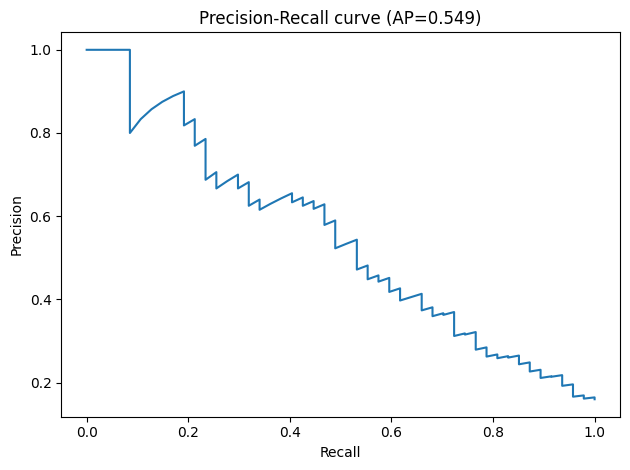

In [10]:
best_name = "LogReg_balanced"  # ou RF si meilleur
p_test = results[best_name]["p_test"]

plot_precision_recall(y_test, p_test)

thr = find_threshold_for_recall(y_test, p_test, target_recall=0.80)
thr

In [11]:
res_thr = evaluate_classifier(models[best_name], X_train, y_train, X_test, y_test, threshold=thr)
print(res_thr["test_report"])
print(res_thr["test_cm"])

2025/12/17 12:34:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2af8a83e28714f00ae219f95052b7466', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/12/17 12:34:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "g:\Mon Drive\OC\Projet_4\technova_attrition\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers 

              precision    recall  f1-score   support

           0      0.941     0.579     0.717       247
           1      0.268     0.809     0.402        47

    accuracy                          0.616       294
   macro avg      0.604     0.694     0.559       294
weighted avg      0.833     0.616     0.666       294

[[143 104]
 [  9  38]]


## Conclusion (baselines)

- Le modèle Dummy sert d’étalon : il montre ce qu’on obtient “sans apprendre”.
- La régression logistique (avec class_weight="balanced") fournit une base interprétable et robuste.
- Le modèle non-linéaire (RandomForest) capte d’éventuelles non-linéarités mais peut sur-apprendre.

Le déséquilibre de classes rend la PR-AUC (Average Precision) particulièrement informative.

Étape suivante :
- validation croisée + grid search (fine tuning)
- puis interprétation avec permutation importance + SHAP sur le modèle retenu
